In [435]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [436]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

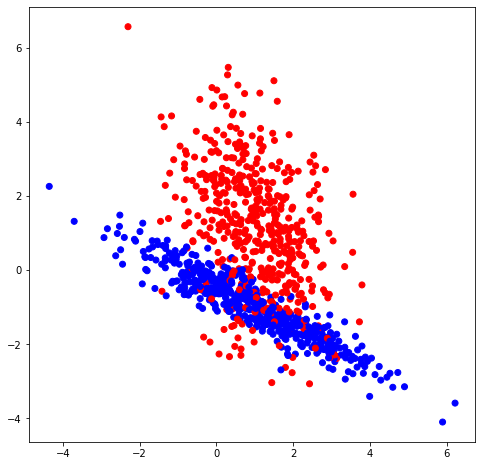

In [437]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [438]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    oob = []
    
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        # oob_data = []
        # oob_labels = []
        b_index = set()
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_index.add(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]

        bootstrap.append((b_data, b_labels))

        oob.append(set(range(data.shape[0])).difference(b_index))


    return bootstrap, oob

In [439]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [440]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [441]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [442]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [443]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [444]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [445]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [446]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [447]:
def rework_oob(oob):
    """
    Recive list of sets_oob_indexes.
    Return dict of lists, where key is number from sets_oob_indexes, and list contain lines index from          oob_list where this number was.
    """
    d = dict()
    for i, s in enumerate(oob):
        for j in s:
            if j not in d:
                d[j] = [i]
            else:
                d[j].append(i)
    return d

Теперь добавим функцию формирования случайного леса.

In [448]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, oob_sets = get_bootstrap(data, labels, n_trees)

    reworked_oob_dict = rework_oob(oob_sets)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    oob = 0
    pred = []
    for i in reworked_oob_dict:
        predictions = np.array([predict([data[i]], forest[model_index]) for model_index in reworked_oob_dict[i]])
        oob += (labels[i] - predictions.mean()) ** 2
     

    return forest, oob / len(reworked_oob_dict)

In [449]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [450]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    # if isinstance(data[0], list):
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    # else:
    #     classes = [[classify_object(data, tree)]]
    return classes

In [451]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [452]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [453]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [454]:
n_trees = 1
my_forest_1, oob = random_forest(train_data, train_labels, n_trees)

In [455]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [456]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [457]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 98.429


In [458]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 95.333


Построим лес из трех деревьев

In [459]:
n_trees = 3
my_forest_3, oob = random_forest(train_data, train_labels, n_trees)

In [460]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [461]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [462]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.714


In [463]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 98.000


Построим лес из десяти деревьев

In [464]:
n_trees = 10
my_forest_10, oob_10 = random_forest(train_data, train_labels, n_trees)

In [465]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [466]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [467]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 100.000


In [468]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 99.000


Построим лес из пятидесяти деревьев

In [469]:
n_trees = 50
my_forest_50, oob = random_forest(train_data, train_labels, n_trees)

In [470]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [471]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [472]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 99.857


In [473]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 98.667


1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [474]:
X , y = datasets.make_classification(n_samples=1000,
                                    n_features = 2, n_informative = 2, 
                                    n_classes = 2, n_redundant=0, 
                                    n_clusters_per_class=1, random_state=400)


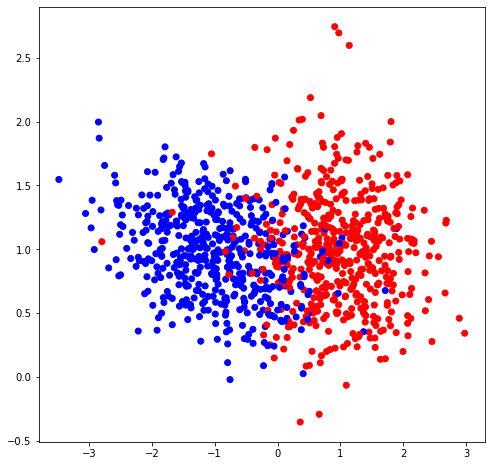

In [475]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(X.T[0], X.T[1], 
              c=y, cmap=colors)

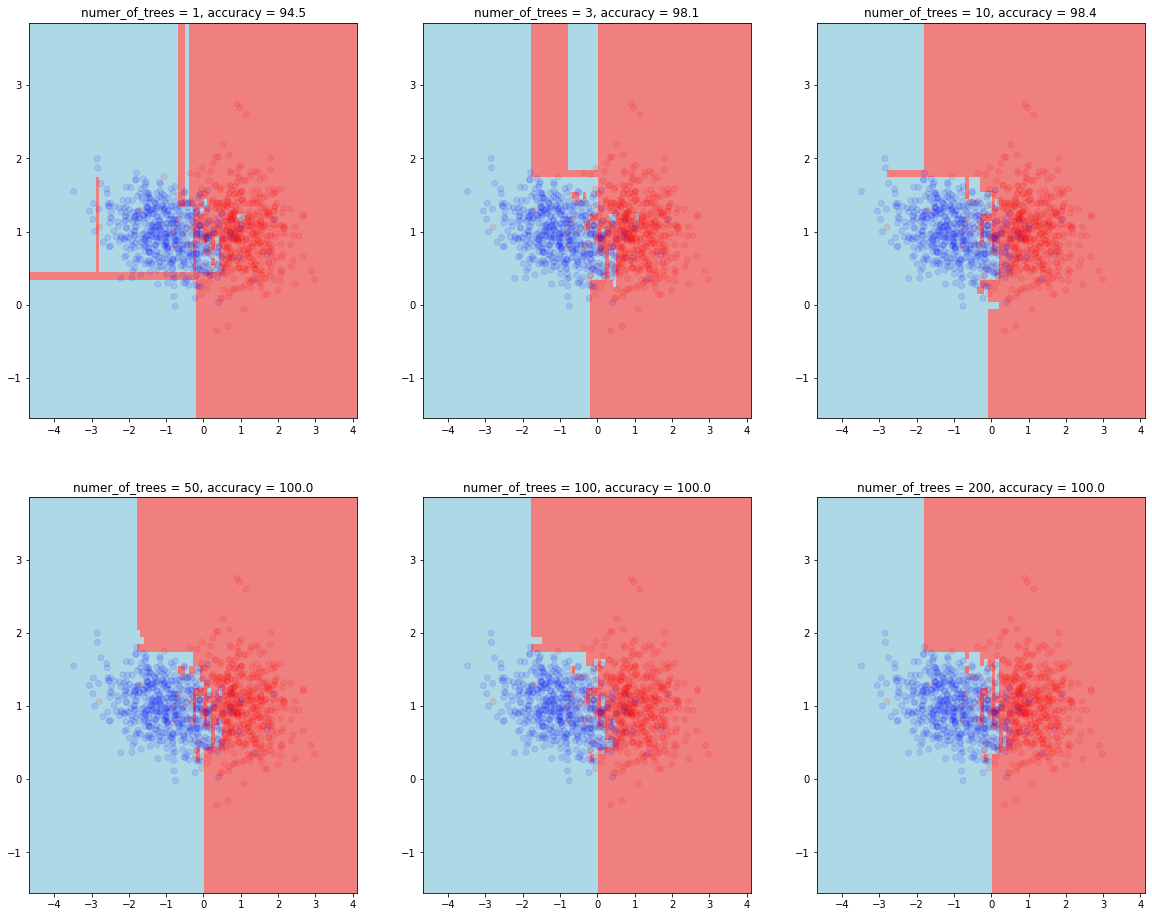

In [476]:
def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
    y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (20, 16))

numbers_of_trees = (1, 3, 10, 50, 100, 200)
for graph_number, n_trees in enumerate(numbers_of_trees):
    my_forest, oob = random_forest(X, y, n_trees)
    plt.subplot(2, len(numbers_of_trees) / 2, graph_number + 1)
    xx, yy = get_meshgrid(X)
   
    predictions = tree_vote(my_forest, X)
    accuracy = accuracy_metric(y, predictions)

    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors, alpha=0.1)
    plt.title(f'numer_of_trees = {numbers_of_trees[graph_number]}, accuracy = {accuracy}')

По графикам видно что модели с 1, 3, 10 страдают от переобученности, начиная с 50 преобученности практически нету. Мне понравился этот датасет своей формой, было интересно как с этим разберется лес.

2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Для этого пришлось модифицировать get_bootstrap, теперь он возвращает номера тех примеров которые были не использованы в каждом дереве. Так же модифицирована функция random_forest: в ней происходит подсчет функции потерь, формулу из методички пришлось чуть чуть модифицировать. При использовании малого числа деревьев, мы не можем пробежаться по всем индексам. так как многие из них побывали во всех деревьях, поэтому мы функцию потерь делим на количество использованных для ее подсчета признаков. Иначе она будет неинформативна.

In [477]:
X , y = datasets.make_classification(n_samples=60,
                                    n_features = 2, n_informative = 2, 
                                    n_classes = 2, n_redundant=0, flip_y=0.3,
                                    n_clusters_per_class=1, random_state=404)

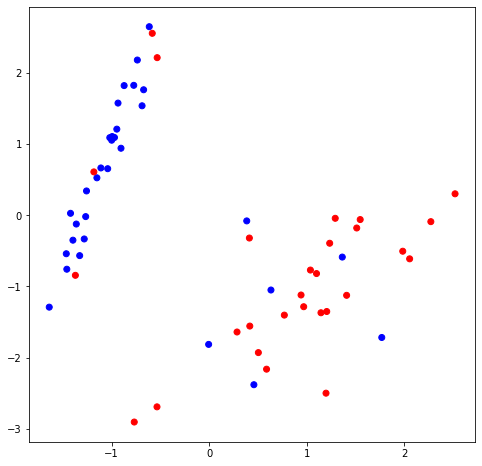

In [478]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(X.T[0], X.T[1], 
              c=y, cmap=colors)

In [479]:
oobs = []
n=100
for j in range(1,n):
    my_forest, oob = random_forest(X, y, j)
    oobs.append(oob)


99


Text(0.5, 0, 'Количество деревьев')

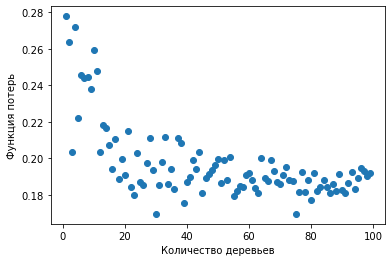

In [480]:
print(len(oobs))
plt.scatter(list(range(1,n)),oobs)
plt.ylabel('Функция потерь')
plt.xlabel('Количество деревьев')